In [1]:
from math import sqrt
from random import seed

import matplotlib.pyplot as plt
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F

plt.rc('font', family='serif', size=8)
plt.rc('text', usetex=True)
th.manual_seed(0)
seed(0)

In [2]:
def get_embeddings(n, d, norm=True):
    emb = th.randn(n, d)
    if norm:
        emb /= emb.norm(dim=1, keepdim=True)
    else:
        emb /= sqrt(d)
    return emb


class AssMem(nn.Module):
    def __init__(self, E, U):
        """
        E: torch.Tensor
            Input embedding matrix of size $n \times d$,
            where $n$ is the number of tokens and $d$ is the embedding dimension.
        U: torch.Tensor
            Output unembedding matrix of size $d \times m$,
            where $m$ is the number of classes and $d$ is the embedding dimension.
        """
        super().__init__()
        d = E.shape[1]
        self.W = nn.Parameter(th.zeros(d, d))
        self.E = E
        self.U = U

    def forward(self, x):
        out = self.E[x] @ self.W
        out = out @ self.U
        return out


class AssMemApprox(nn.Module):
    def __init__(self, E, U, all_y):
        """
        E: torch.Tensor
            Input embedding matrix of size $n \times d$,
            where $n$ is the number of tokens and $d$ is the embedding dimension.
        U: torch.Tensor
            Output unembedding matrix of size $d \times m$,
            where $m$ is the number of classes and $d$ is the embedding dimension.
        """
        super().__init__()
        d = E.shape[1]
        self.m = U.shape[1]
        self.n = E.shape[0]
        self.q = th.zeros(self.n, dtype=th.float32)
        self.E2 = E @ E.T
        self.U2 = U[:, all_y].T @ U

    def update(self, x, gamma):
        grad = th.exp(self.q) / (self.m - 1)
        grad = 1 / (1+ grad)
        grad *= th.bincount(x, minlength=self.n)
        self.q += gamma * grad

    def prediction(self):
        return (self.E2 * self.q) @ self.U2

In [27]:
# number of input tokens
n = 100
# number of output classes
m = 5
# memory dimension
d = 10

# Zipf parameter
alpha = 2

In [28]:
# Population data
all_x = th.arange(n)
proba = (all_x + 1.) ** (-alpha)
proba /= proba.sum()
all_y = all_x % m

In [29]:
# number of data
batch_size = 1000
nb_epoch = 100
T = nb_epoch * batch_size

In [30]:
lr = 1e0
nb_trials = 100

errors = th.zeros(2, nb_trials, nb_epoch)
errors[:] = -1


for i_t in range(nb_trials):
    # Embeddings
    E = get_embeddings(n, d, norm=False)
    U = get_embeddings(m, d, norm=True).T

    model = AssMem(E, U)
    opti = th.optim.SGD(model.parameters(), lr=lr)

    approx_model = AssMemApprox(E, U, all_y)

    for i_e in range(nb_epoch):
        x = th.multinomial(proba, batch_size, replacement=True)
        y = x % m

        # real update
        out = model(x)
        loss = F.cross_entropy(out, y)
        opti.zero_grad()
        loss.backward()
        opti.step()

        # approx update
        approx_model.update(x, lr / batch_size)

        with th.no_grad():
            pred = model(all_x).argmax(dim=-1)
            errors[0, i_t, i_e] = proba[pred != all_y].sum().item()

            approx_pred = approx_model.prediction().argmax(dim=-1)
            errors[1, i_t, i_e] = proba[approx_pred != all_y].sum().item()

    print(i_t, end=',')

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,

In [31]:
mean_errors = errors.mean(dim=1).numpy()
std_errors = errors.std(dim=1).numpy()

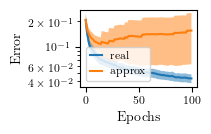

In [32]:
fig, ax = plt.subplots(figsize=(1.5, 1))
leg = []
for i in range(2):
    a, = ax.plot(mean_errors[i])
    ax.fill_between(np.arange(nb_epoch), mean_errors[i] - .5*std_errors[i],
                    mean_errors[i] + .5*std_errors[i], alpha=.5)
    leg.append(a)

ax.set_yscale('log')
ax.set_xlabel('Epochs', fontsize=10)
ax.set_ylabel('Error', fontsize=10)
plt.legend(leg, ['real', 'approx'], loc="best", fontsize=8, handlelength=1, frameon=True)
fig.savefig(f'approx_sgd_{d}_{batch_size}.pdf', bbox_inches='tight')

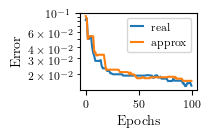

In [26]:
fig, ax = plt.subplots(figsize=(1.5, 1))
leg = []
for i in range(2):
    a, = ax.plot(errors[i, 0])
    leg.append(a)

ax.set_yscale('log')
ax.set_xlabel('Epochs', fontsize=10)
ax.set_ylabel('Error', fontsize=10)
plt.legend(leg, ['real', 'approx'], loc="best", fontsize=8, handlelength=1)
fig.savefig(f'approx_sgd_{d}_{batch_size}_one_run.pdf', bbox_inches='tight')